In [1]:
from jaxgym.ode import odedopri,  electron_equation_of_motion_DA
from jaxgym.field import schiske_lens_expansion_xyz, obtain_first_order_electrostatic_lens_properties
import jaxgym.components as comp
from jaxgym.ray import Ray
from jaxgym.run import run_to_end, calculate_derivatives
from jaxgym.taylor import poly_dict, order_indices, poly_dict_to_sympy_expr

import jax
import jax.numpy as jnp
import numpy as np
import optimistix as optx

from scipy.constants import h as h_planck, e, m_e
from daceypy import array, DA
import sympy as sp
import os

from scipy.integrate import simpson

import matplotlib.pyplot as plt

jax.config.update("jax_platform_name", "gpu")
jax.config.update("jax_enable_x64", True)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


%matplotlib widget

/home/dl277493/JaxTemGym/src/jaxgym/ode.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [2]:
X, Y, Z = sp.symbols('X Y Z')

scale = 1 #set to mm scale
# Set Parameters for Schiske Electrostatic Lens
# Define lens parameters

z_init = -0.015*scale  # Convert m to um units
a = 0.0004*scale  # Convert m to um units
phi_0 = 1000  # Volts

k = 0.4**(1/2)  # Unitless

(
    phi_expansion_symbolic,
    E_lambda, phi_lambda,
    phi_lambda_axial,
    phi_lambda_prime,
    phi_lambda_double_prime,
    phi_lambda_quadruple_prime,
    phi_lambda_sextuple_prime
) = schiske_lens_expansion_xyz(X, Y, Z, phi_0, a, k)

wavelength = h_planck/(2*abs(e)*m_e*phi_lambda_axial(z_init))**(1/2)*scale


z_pos, g, g_, h, h_, mag_real, z_image, z_focal_real, z_focal_asymp, z_pi = obtain_first_order_electrostatic_lens_properties(
    z_init, phi_lambda_axial, phi_lambda_prime, phi_lambda_double_prime, z_sampling=1000)

R_image_to_aperture = np.abs(z_init)
p_I = phi_lambda_axial(z_image)
p_O = phi_lambda_axial(z_init)

Uz0 = phi_lambda_axial(z_pos[0])

U_val = phi_lambda_axial(z_pos)
U_val_ = phi_lambda_prime(z_pos)
U_val__ = phi_lambda_double_prime(z_pos)
U_val____ = phi_lambda_quadruple_prime(z_pos)

def L_1():
    return (1/(32*jnp.sqrt(U_val)))*((U_val__**2)/(U_val)-U_val____)


def L_2():
    return (1/(8*jnp.sqrt(U_val)))*(U_val__)


def L_3():
    return 1/2*(jnp.sqrt(U_val))


def F_020():
    return (L_1()/4)*h*h*h*h + (L_2()/2)*h*h*h_*h_ + (L_3()/4)*h_*h_*h_*h_

Cs = 4/jnp.sqrt(abs(Uz0))*simpson(F_020(), x=z_pos)*mag_real
B = simpson(F_020(), x=z_pos)

print('Cs in metres (Aberration Integral Method):', Cs)
print('B in metres (Aberration Integral Method):', B)


Cs in metres (Aberration Integral Method): -110.45565393413894
B in metres (Aberration Integral Method): 523.0275451946878


In [3]:
order = 4

DA.init(order, 5)

x0 = 0.
y0 = 0.
x0_slope = 0.0
y0_slope = 0.0
opl = 0.

z_init_nondm = z_init
z_image_nondm = z_image

In [4]:

u0 = phi_lambda_axial(z_init)  # initial potential
x = array([x0 + DA(1), y0 + DA(2), x0_slope + DA(3), y0_slope + DA(4), opl + DA(5)])

# solve the equation of motion via the differential algebra method, which delivers the solution as a taylor expansion
with DA.cache_manager():
    zf, x_f = odedopri(electron_equation_of_motion_DA, 
                       x0 = z_init_nondm,
                       y0 = x, 
                       x1 = z_image_nondm,  
                       tol = 1e-1, 
                       hmax = 1000000, 
                       hmin = 1e-15,  
                       maxiter =int(1e5), 
                       args=(phi_lambda, E_lambda, u0))
    
Cs_daceypy = x_f[0].getCoefficient([0, 0, 3, 0])

  0%|          | 0/100000 [00:00<?, ?it/s]

z = 0.02504562690653778


In [5]:
Cs = 4/jnp.sqrt(abs(Uz0))*simpson(F_020(), x=z_pos)*mag_real
print('Cs (Aberration Integral Method):', Cs)
print('Cs (DA) - x polynomial', Cs_daceypy)
print('Cs (DA) - opl polynomial', x_f[4].getCoefficient([0, 0, 4, 0, ]) * 4 / 3 * mag_real)


Cs (Aberration Integral Method): -110.45565393413894
Cs (DA) - x polynomial -110.45567442763928
Cs (DA) - opl polynomial -110.45567442927711


In [6]:
z_init = jnp.array(z_init)
z_image = jnp.array(z_image)

PointSource = comp.InputPlane(z=z_init)
ElectrostaticLens = comp.ODE(z=z_init, z_end=z_image, phi_lambda=phi_lambda, E_lambda=E_lambda)
Detector = comp.Detector(z=z_image, det_pixel_size=(5e-9 * scale, 5e-9 * scale), det_shape = (128, 128))
model = [PointSource, ElectrostaticLens, Detector]

det_coords = Detector.get_coords()

In [11]:
ray = Ray(0., 0., 0., 0., 0., z_init, 0.0)
ray_out = run_to_end(ray, model)

derivatives = calculate_derivatives(ray, model, order)

In [31]:
selected_vars = ['x', 'y', 'dx', 'dy', 'pathlength']
multi_indices = order_indices(order, n_vars=len(selected_vars))

In [32]:
poly_dicts = poly_dict(derivatives, selected_vars, multi_indices[1:])

In [33]:
x_var, y_var, dx_var, dy_var, x_out, y_out, dx_out, dy_out, opl_var = sp.symbols("x y x' y' x_out y_out dx_out, dy_out S", real=True)
x_a, y_a = sp.symbols("x_a y_a", real=True)
polynomials = poly_dict_to_sympy_expr(poly_dicts, selected_vars, sym_vars=[x_var, y_var, dx_var, dy_var, opl_var])

In [69]:

polynomials['pathlength'] = polynomials['pathlength'].subs({opl_var: 0})

dSdxodxp = sp.diff(polynomials['pathlength'], x_var, dx_var)
dXdx = sp.diff(polynomials['x'], x_var)
dSdxodyp = sp.diff(polynomials['pathlength'], x_var, dy_var)
dSdyodxp = sp.diff(polynomials['pathlength'], y_var, dx_var)
dSdyodyp = sp.diff(polynomials['pathlength'], y_var, dy_var)

print('dSdxodxp', dSdxodxp)
print('dXdx', dXdx)

hessian = sp.Matrix([[dSdxodxp, dSdxodyp], [dSdyodxp, dSdyodyp]])
amplitude = 1 / sp.sqrt(hessian.det()) * 1 / (wavelength * 1j)
amplitude = sp.lambdify([x_var, y_var, dx_var, dy_var], amplitude, modules='jax')


dSdxodxp 470203814.329094*x**2 + 11170817.4283819*x*x' + 61754.9193590125*x'**2 + 156734604.776365*y**2 + 3723520.53965758*y*y' + 20584.9731196708*y'**2 - 8.96939744698953e-11
dXdx -98047190.7680926*x**2 - 2942035.73618572*x*x' - 22075.4367989754*x'**2 - 32682396.9226976*y**2 - 980536.235484953*y*y' - 7358.47893307008*y'**2 - 1.66932795816331


In [68]:
np.sqrt(phi_0)

np.float64(31.622776601683793)

In [73]:
# Print the coefficients of dSdxodxp / dXdx simplified
# I want the individual coefficients divided by each other as a float printed

coeffs_S = dSdxodxp.as_coefficients_dict()
coeffs_X = dXdx.as_coefficients_dict()
print('coeffs_S', coeffs_S)
print('coeffs_X', coeffs_X)

# For each key in both coeffs, print the value of coeffs_S[key] / coeffs_X[key]
for key in coeffs_S.keys():
    if key in coeffs_X:
        coeff = coeffs_S[key] / (coeffs_X[key] * mag_real)
        print(f'coeff factor {key}:', coeff)
    else:
        print(f'key {key} not in coeffs_X')


coeffs_S defaultdict(<class 'int'>, {1: -8.96939744698953e-11, x**2: 470203814.329094, y**2: 156734604.776365, y'**2: 20584.9731196708, x'**2: 61754.9193590125, x*x': 11170817.4283819, y*y': 3723520.53965758})
coeffs_X defaultdict(<class 'int'>, {1: -1.66932795816331, y'**2: -7358.47893307008, y**2: -32682396.9226976, x'**2: -22075.4367989754, x**2: -98047190.7680926, y*y': -980536.235484953, x*x': -2942035.73618572})
coeff factor 1: -3.21869580881337e-11
coeff factor x**2: 2.87282602155853
coeff factor y**2: 2.87282602155853
coeff factor y'**2: 1.67579382690537
coeff factor x'**2: 1.67579382692320
coeff factor x*x': 2.27454924087604
coeff factor y*y': 2.27482734013315


In [35]:
jax_poly_x = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['x'], modules='jax')
jax_poly_y = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['y'], modules='jax')
jax_poly_dx = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['dx'], modules='jax')
jax_poly_dy = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['dy'], modules='jax')
jax_poly_opl = sp.lambdify([x_var, y_var, dx_var, dy_var], polynomials['pathlength'], modules='jax')

In [36]:
from functools import partial
@partial(jax.jit, static_argnames=['num_x', 'num_y'])
def simpson2d(f, ax, bx, ay, by, num_x, num_y):
  """
  Evaluate a 2D integral using Simpson's rule for potentially different
  numbers of points in the x and y dimensions.

  Parameters:
    f (ndarray): 1D array of ravelled 2D function values.
    ax, bx (float): Integration bounds for x.
    ay, by (float): Integration bounds for y.
    num_x (int): Number of points in x dimension.
    num_y (int): Number of points in y dimension.

  Returns:
    float: Approximate value of the integral.
  """
  hx = (bx - ax) / (num_x - 1)
  hy = (by - ay) / (num_y - 1)

  idx_x = jax.lax.iota(jnp.int32, num_x)
  wx = 4 - 2 * (idx_x % 2)
  wx = wx.at[0].set(1)
  wx = wx.at[-1].set(1)
  
  idx_y = jax.lax.iota(jnp.int32, num_y)
  wy = 4 - 2 * (idx_y % 2)
  wy = wy.at[0].set(1)
  wy = wy.at[-1].set(1)

  # Construct the 2D weight matrix as an outer product.
  weights = jnp.outer(wx, wy).ravel()
  
  # Multiply by hx*hy/9 based on Simpson's rule in two dimensions.
  return hx * hy / 9 * jnp.sum(f * weights)


In [37]:
from tqdm import tqdm

sample_object = plt.imread(r'SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
sample_object = sample_object[1:-1, 1:-1]  # Crop the image to remove borders
sample_shape = sample_object.shape

object_x = jnp.linspace(-1e-7, 1e-7, sample_shape[0])
object_y = jnp.linspace(-1e-7, 1e-7, sample_shape[1])
object_x, object_y = jnp.meshgrid(object_x, object_y)
object_x = object_x.ravel()
object_y = object_y.ravel()

x_det_shape, y_det_shape = Detector.det_shape

# flatten detector coordinates
x_det = det_coords[:, 0].ravel()
y_det = det_coords[:, 1].ravel()


@jax.jit
def solve_slopes(x_input, y_input, x_det_pixel, y_det_pixel):
    
    # Find the slope of the ray in the input plane that will land on the desired detector pixel
    def input_slope_from_image_position_loss(params, args):
        dx, dy = params
        x_in, y_in, x_out, y_out = args
        res_x = jax_poly_x(x_in, y_in, dx, dy) - x_out 
        res_y = jax_poly_y(x_in, y_in, dx, dy) - y_out

        return res_x, res_y

    slope_in_x, slope_in_y = optx.root_find(
        input_slope_from_image_position_loss,
        optx.Newton(rtol=1e-14, atol=1e-14),
        jnp.array([0., 0.]), # initial guess for slopes
        (x_input, y_input, x_det_pixel, y_det_pixel)
    ).value
    
    return slope_in_x, slope_in_y

solve_slopes_vmap = jax.vmap(solve_slopes, in_axes=(None, None, 0, 0))

def compute_wave(x_input, y_input):
    dx_input, dy_input = solve_slopes_vmap(x_input, y_input, x_det, y_det)
    opl = jax_poly_opl(x_input, y_input, dx_input, dy_input)

    phase = (2*jnp.pi*(opl/wavelength) + jnp.pi) % (2*jnp.pi) - jnp.pi
    amp = amplitude(x_input, y_input, dx_input, dy_input)

    kernel = jnp.exp(1j*phase) * amp
    return kernel

dx = Detector.det_pixel_size[0]
dy = Detector.det_pixel_size[1]

def compute_integral(U, x_input, y_input):
    wave_detector = compute_wave(x_input, y_input)
    out = wave_detector * U * dx * dy

    return out

Uobject = jnp.ravel(sample_object)
Uobject = jnp.array(Uobject, dtype=jnp.complex128)
Uobject = jnp.abs(Uobject) * jnp.exp(1j * jnp.abs(Uobject))

compute_integral_batch = jax.jit(jax.vmap(compute_integral, 
                                          in_axes=(0, 0, 0)))

batch_size = 500  # number of pixels per batch
num_pixels = Uobject.shape[0]
output = jnp.zeros(len(x_det), dtype=jnp.complex128)

for i in tqdm(range(0, num_pixels, batch_size), leave=True):
    U_batch = Uobject[i:i+batch_size]
    x_batch = object_x[i:i+batch_size]
    y_batch = object_y[i:i+batch_size]
    
    det_wave_batch = compute_integral_batch(
        U_batch,                   # Input Object Wavefunction
        x_batch,                   # Object x-coordinates
        y_batch,                   # Object y-coordinates
    )
    output += det_wave_batch.sum(axis=0)

output = output.reshape((x_det_shape, y_det_shape))

  0%|          | 0/88 [00:00<?, ?it/s]

100%|██████████| 88/88 [00:32<00:00,  2.73it/s]


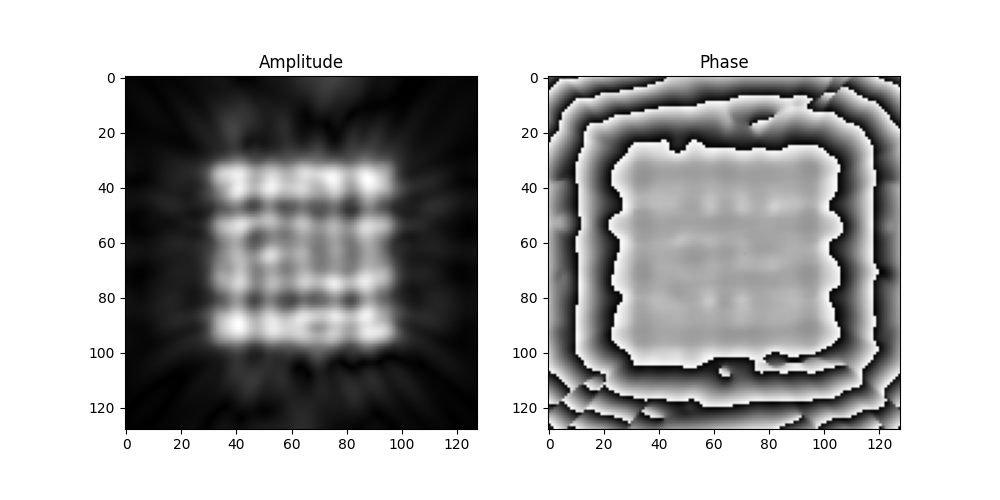

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.abs(output), cmap='gray')
ax[0].set_title('Amplitude')
ax[1].imshow(np.angle(output), cmap='gray')
ax[1].set_title('Phase')
plt.show()


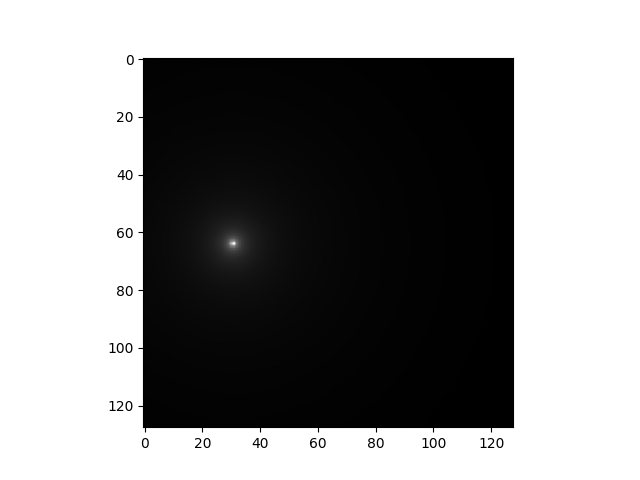

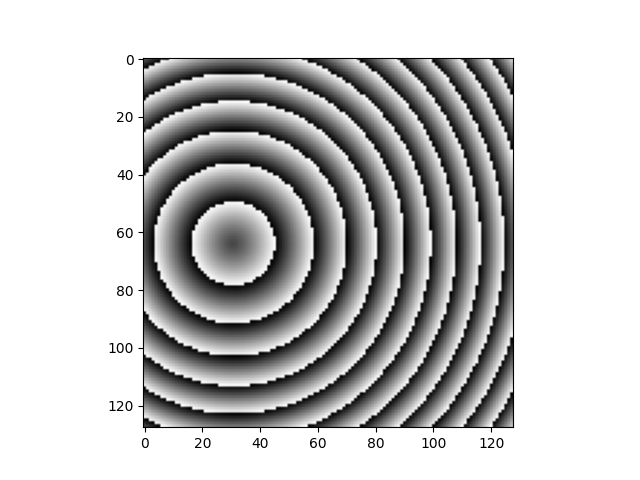

In [39]:
z_input_aperture = 0.0
z_output_aperture = 0.0

n_rays = Detector.det_shape[0]
x_input, y_input = 1e-7, 0.
dx_input, dy_input = solve_slopes_vmap(x_input, y_input, x_det, y_det)

output_rays_x = jax_poly_x(x_input, y_input, dx_input, dy_input)
output_rays_y = jax_poly_y(x_input, y_input, dx_input, dy_input)
output_rays_dx = jax_poly_dx(x_input, y_input, dx_input, dy_input)
output_rays_dy = jax_poly_dy(x_input, y_input, dx_input, dy_input)

amp = amplitude(x_input, y_input, dx_input, dy_input)
opl = jax_poly_opl(x_input, y_input, dx_input, dy_input)
phase = (2*jnp.pi*(opl/wavelength) + jnp.pi) % (2*jnp.pi) - jnp.pi
phase = phase.reshape((x_det_shape, y_det_shape))
amp = amp.reshape((x_det_shape, y_det_shape))

wave = jnp.exp(1j*phase) * amp * dx * dy

plt.figure()
plt.imshow(np.abs(wave), cmap='gray')
plt.show()

plt.figure()
plt.imshow(np.angle(wave), cmap='gray')
plt.show()
# input_aperture_rays_x = input_rays_x + dx_input * abs(z_init)
# input_aperture_rays_y = input_rays_y + dy_input * abs(z_init)

# output_aperture_rays_x = output_rays_x + output_rays_dx * -z_image
# output_aperture_rays_y = output_rays_y + output_rays_dy * -z_image


# plt.figure()
# plt.plot([z_init, z_input_aperture], [input_rays_x[:n_rays], input_aperture_rays_x[:n_rays]], 'r-')
# plt.plot([z_input_aperture, z_image], [output_aperture_rays_x[:n_rays], output_rays_x[:n_rays]], 'b-')
# plt.plot(np.full(det_coords[:n_rays, 0].shape, z_image), det_coords[:n_rays, 0], 'k.')

In [40]:
var = 'pathlength'

if var == 'x':
    var_idx = 0
elif var == 'y':
    var_idx = 1
elif var == 'dx':
    var_idx = 2
elif var == 'dy':
    var_idx = 3
elif var == 'pathlength':
    var_idx = 4
else:
    raise ValueError(f"Unknown variable: {var}")

header = f"{'I':>6}  {'COEFFICIENT':>3}   {'ORDER':>16} {'EXPONENTS':>4}"
const = f"{1:6d}   {getattr(ray_out, var): .16e}   {0} {'  0  0  0  0  0':15s}"

print_jax = [header, const]
for idx, entry in enumerate(poly_dicts[var]):
    exponents = tuple(map(int, entry[:-1]))
    coeff = entry[-1]
    total_order = sum(exponents)
    exponents_str = " ".join(f"{e:2d}" for e in exponents)
    print_jax.append(f"{idx:6d}   {coeff: .16e}   {total_order}  {exponents_str}")
print_jax.append('------------------------------------------------')


header = f"{'I':>6}  {'COEFFICIENT':>3}   {'ORDER':>16} {'EXPONENTS':>4}"
const = f"{1:6d}   {x_f[var_idx].getCoefficient([0, 0]): .16e}   {0} {'  0  0  0  0  0':15s}"

print_daceypy = [header, const]

for idx, entry in enumerate(poly_dicts[var]):
    exponents = tuple(map(int, entry[:-1]))
    coeff = x_f[var_idx].getCoefficient(list(exponents))
    total_order = sum(exponents)
    exponents_str = " ".join(f"{e:2d}" for e in exponents)
    print_daceypy.append(f"{idx:6d}   {coeff: .16e}   {total_order}  {exponents_str}")
print_daceypy.append('------------------------------------------------')

# Print the two blocks side by side
for left, right in zip(print_jax, print_daceypy):
    print(f"{left:<60} {right}")


     I  COEFFICIENT              ORDER EXPONENTS                  I  COEFFICIENT              ORDER EXPONENTS
     1    3.9788388116232719e-02   0   0  0  0  0  0              1    3.9788388116234773e-02   0   0  0  0  0  0
     0    9.9999999999999911e-01   1   0  0  0  0  1              0    1.0000000000000000e+00   1   0  0  0  0  1
     1   -3.9226553862764574e-13   2   0  0  0  2  0              1    5.6219745113612885e-14   2   0  0  0  2  0
     2   -8.9693974469895310e-11   2   0  1  0  1  0              2    1.7311093530869570e-11   2   0  1  0  1  0
     3   -3.9226553862764574e-13   2   0  0  2  0  0              3    5.6219745113612885e-14   2   0  0  2  0  0
     4   -8.9693974469895310e-11   2   1  0  1  0  0              4    1.7311093530869570e-11   2   1  0  1  0  0
     5    8.8932114097922550e+01   2   0  2  0  0  0              5    8.8932114103233459e+01   2   0  2  0  0  0
     6    8.8932114097922550e+01   2   2  0  0  0  0              6    8.8932114103233459e+0